In [1]:
import json
import os
from pathlib import Path
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np 
from tqdm import tqdm
from torch.utils.data import DataLoader
from scipy.spatial.transform import Rotation as R
import cv2
import math
from torchvision.models import resnet18
import sys
sys.path.append(os.path.abspath(os.path.join('..', 'utils')))
from load_data import load_data

In [2]:
obj_diameter = 0.24

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class BasicCNN(nn.Module):
    def __init__(self, dropout_p = 0.5):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding='same')
        self.batch1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding='same')
        self.batch2 = nn.BatchNorm2d(32)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(32*32*32, 256)
        self.batch = nn.BatchNorm1d(256)
        # 3 for translation and 6 for rotation based on "On the Continuity of Rotation Representations in Neural Networks"
        self.fc2 = nn.Linear(256, 9)
        
    def forward(self, x):
        x1 = self.pool(F.gelu(self.batch1(self.conv1(x))))
        x2 = self.pool(F.gelu(self.batch2(self.conv2(x1))))
        x4 = self.dropout(self.flatten(x2))
        x5 = F.gelu(self.batch(self.fc1(x4)))
        out = self.fc2(x5)
        transl = out[:, :3]
        rot_r1 = out[:, 3:6]
        rot_r2 = out[:, 6:9]
        R1 = rot_r1 / torch.norm(rot_r1, dim=1).view(-1, 1)
        R3 = torch.cross(R1, rot_r2)
        R3 = R3 / torch.norm(R3, dim=1).view(-1, 1)
        R2 = torch.cross(R3, R1)
        rotmat = torch.stack([R1, R2, R3], dim=2)
        out = torch.cat([transl, rotmat.flatten(start_dim=1)], dim=1)
        return out
    
    def save(self, path):
        torch.save(self.state_dict(), path)
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        return self

class Resnet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet18()
        self.model.fc = nn.Linear(512, 9)
    
    def forward(self, x):
        out = self.model(x)
        transl = out[:, :3]*obj_diameter
        rot_r1 = out[:, 3:6]
        rot_r2 = out[:, 6:9]
        R1 = rot_r1 / torch.norm(rot_r1, dim=1).view(-1, 1)
        R3 = torch.cross(R1, rot_r2)
        R3 = R3 / torch.norm(R3, dim=1).view(-1, 1)
        R2 = torch.cross(R3, R1)
        rotmat = torch.stack([R1, R2, R3], dim=2)
        out = torch.cat([transl, rotmat.flatten(start_dim=1)], dim=1)
        return out
    
    def save(self, path):
        torch.save(self.model.state_dict(), path)
    
    def load(self, path):
        self.model.load_state_dict(torch.load(path))
        return self

Using cuda device


In [4]:
class Trainer():
    def __init__(self, 
                 model, 
                 optimizer,
                 loss_fn,
                 lr_scheduler,
                 train_data,
                 val_data,
                 device,
                 num_epochs: int, 
                 training_save_dir,
                 batch_size: int = 4,
                 val_frequency: int = 1) -> None:
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.lr_scheduler = lr_scheduler
        self.train_data = train_data
        self.val_data = val_data
        self.device = device
        self.num_epochs = num_epochs
        self.training_save_dir = training_save_dir
        self.batch_size = batch_size
        self.val_frequency = val_frequency
        self.train_loader = torch.utils.data.DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False)

    def _train_epoch(self, epoch_idx: int):
        self.model.train()
        train_loss = 0
        for batch, (X, y) in enumerate(self.train_loader):
            X, y = X.to(self.device), y.to(self.device)

            # Compute prediction error
            pred = self.model(X)
            loss = self.loss_fn(pred, y)
            train_loss += loss.item()

            # Backpropagation
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        
        train_loss /= len(self.train_loader)
        print(f"train loss: {train_loss}")
        return train_loss

        
    def _val_epoch(self, epoch_idx:int):
        num_batches = len(self.val_loader)
        self.model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in self.val_loader:
                X, y = X.to(self.device), y.to(self.device)
                pred = self.model(X)
                val_loss += self.loss_fn(pred, y).item()
        val_loss /= num_batches
        print(f"val loss: {val_loss}")
        return val_loss

    def train(self) -> None:
        best_val_loss = np.inf
        for epoch_idx in tqdm(range(self.num_epochs)):
            train_loss = self._train_epoch(epoch_idx)
            if epoch_idx % self.val_frequency == 0 or epoch_idx == self.num_epochs - 1:
                val_loss = self._val_epoch(epoch_idx)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    self.model.save(f"{self.training_save_dir}/{self.model.name}_best")
            self.lr_scheduler.step()

In [5]:
class FlowImageDataset():
    def __init__(self, flow_image_path, poses_path, seed=42, subset=None, transform=None):
        for path in [flow_image_path, poses_path]:
            if not os.path.exists(path):
                raise FileNotFoundError(f"File {path} does not exist.")
        self.transform = transform
        flow_images = []
        flow_image_names = []
        for file in sorted(os.listdir(flow_image_path)):
            if not file.endswith(".npy"):
                raise ValueError(f"File {file} is not a .npy file.")
            flow_image = np.load(os.path.join(flow_image_path, file)).astype(np.float32)
            height, width, _ = flow_image.shape
            # Use Hue, Saturation, Value colour model 
            hsv = np.zeros((height, width, 3), dtype=np.uint8)
            hsv[..., 1] = 255
            mag, ang = cv2.cartToPolar(flow_image[..., 0], flow_image[..., 1])
            hsv[..., 0] = (ang * 180 / np.pi / 2)
            hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
            flow_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
            flow_image = np.transpose(flow_image, (2, 0, 1))
            flow_image = torch.tensor(flow_image, dtype=torch.float32).unsqueeze(0)
            flow_images.append(flow_image)
            flow_image_names.append(file[:-4])
        self.flow_images = torch.cat(flow_images, 0)
        np.random.seed(seed)
        random_idx = np.arange(self.flow_images.shape[0])
        np.random.shuffle(random_idx)
        if subset == "train":
            train_idx = random_idx[:int(0.8*len(random_idx))]
            self.flow_images = self.flow_images[train_idx]
            self.flow_image_names = [flow_image_names[i] for i in train_idx]
        elif subset == "val":
            val_idx = random_idx[int(0.8*len(random_idx)):int(0.9*len(random_idx))]
            self.flow_images = self.flow_images[val_idx]
            self.flow_image_names = [flow_image_names[i] for i in val_idx]
        elif subset == "test":
            test_idx = random_idx[int(0.9*len(random_idx)):]
            self.flow_images = self.flow_images[test_idx]
            self.flow_image_names = [flow_image_names[i] for i in test_idx]
        
        poses = {}
        for folder in sorted(os.listdir(poses_path)):
            if 'flow_images' in folder:
                continue
            with open(os.path.join(poses_path, folder, 'poses.json')) as f:
                pose = json.load(f)
            poses[folder] = pose
        transforms = np.empty((len(self.flow_image_names), 4, 4))
        for idx, image_name in enumerate(self.flow_image_names):
            obj_src = image_name.split("__")[0]
            obj_ref = image_name.split("__")[1]
            cam_id_src = obj_src.split("_")[-1]
            object_name_src = obj_src[:-len(cam_id_src)-1]
            cam_id_ref = obj_ref.split("_")[-1]
            object_name_ref = obj_ref[:-len(cam_id_ref)-1]

            obj_src_pose = poses[object_name_src][object_name_src]
            cam_src_pose = poses[object_name_src]['cam_'+str(cam_id_src)]
            cam_to_obj_src = np.linalg.inv(cam_src_pose) @ obj_src_pose

            obj_ref_pose = poses[object_name_ref][object_name_ref]
            cam_ref_pose = poses[object_name_ref]['cam_'+str(cam_id_ref)]
            cam_to_obj_ref = np.linalg.inv(cam_ref_pose) @ obj_ref_pose

            transform = cam_to_obj_src @ np.linalg.inv(cam_to_obj_ref)
            transforms[idx] = transform

        self.y = torch.tensor(transforms, dtype=torch.float32)
        print(self.y.shape)

    def __len__(self):
        return self.flow_images.shape[0]
    
    def __getitem__(self, idx):
        flow_image = self.flow_images[idx]
        if self.transform:
            flow_image = self.transform(flow_image)
        y_transl = self.y[idx, :3, 3]
        y_rot = self.y[idx, :3, :3]
        y = torch.cat([y_transl, y_rot.flatten()])
        return flow_image, y

In [6]:
flow_images_path = Path("../../output", "flow_images")
poses_path = Path("../../output", "dataset_rendered")
train_ds = FlowImageDataset(flow_image_path=flow_images_path, poses_path=poses_path, subset="train")
val_ds = FlowImageDataset(flow_image_path=flow_images_path, poses_path=poses_path, subset="val")
test_ds = FlowImageDataset(flow_image_path=flow_images_path, poses_path=poses_path, subset="test")

torch.Size([3276, 4, 4])
torch.Size([410, 4, 4])
torch.Size([410, 4, 4])


In [7]:
alpha = 1/3
gamma = 1/4
beta = 0.5

def my_loss(pred, target):
    pred[:, :3] = pred[:, :3]
    transl_loss = alpha*torch.mean((pred[:, :3] - target[:, :3])**2)
    rot_loss = beta*gamma/8*torch.mean((pred[:, 3:] - target[:, 3:])**2)
    return (transl_loss + rot_loss)
    

def train(model, train_data, val_data, num_epochs=30, lr=0.01, gamma=0.98, device='cuda', batch_size=32):
    optimizer = torch.optim.AdamW(model.parameters(), amsgrad=True, lr=lr) 
    val_frequency = 1
    loss_fn = my_loss

    model_save_dir = Path("saved_models")
    model_save_dir.mkdir(exist_ok=True)

    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    
    trainer = Trainer(model, 
                    optimizer,
                    loss_fn,
                    lr_scheduler,
                    train_data,
                    val_data,
                    device,
                    num_epochs, 
                    model_save_dir,
                    batch_size, # feel free to change
                    val_frequency = val_frequency)
    trainer.train()
    return model

In [8]:
model = BasicCNN().to(device)
model.name = "basic_cnn"
model = Resnet18().to(device)
model.name = "resnet18"

model = train(model, train_ds, val_ds, num_epochs=50, device=device, batch_size=32)

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_31312/3299265292.py:63: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/Cross.cpp:62.)
  R3 = torch.cross(R1, rot_r2)
/home/lexi/miniconda3/envs/flowpose/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/lexi/miniconda3/envs/flowpose/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan fa

train loss: 0.04597313958898332
val loss: 0.03678800638478536


  2%|▏         | 1/50 [00:05<04:20,  5.32s/it]

train loss: 0.033701447878503106
val loss: 0.032472383230924606


  4%|▍         | 2/50 [00:10<04:01,  5.04s/it]

train loss: 0.028100856362832983
val loss: 0.027367170040424053


  8%|▊         | 4/50 [00:19<03:43,  4.86s/it]

train loss: 0.02433497809524675
val loss: 0.03996599164719765
train loss: 0.02232560721560589
val loss: 0.026841812552167818


 10%|█         | 5/50 [00:24<03:38,  4.86s/it]

train loss: 0.02022707521083575
val loss: 0.02102890109213499


 14%|█▍        | 7/50 [00:34<03:28,  4.85s/it]

train loss: 0.018991377078069065
val loss: 0.022023858574147407
train loss: 0.016557525038646843


 16%|█▌        | 8/50 [00:39<03:22,  4.83s/it]

val loss: 0.024500097864522383


 18%|█▊        | 9/50 [00:43<03:17,  4.83s/it]

train loss: 0.015123052793799096
val loss: 0.05342871581132595
train loss: 0.014286225539568848
val loss: 0.018332075184354417


 20%|██        | 10/50 [00:48<03:16,  4.91s/it]

train loss: 0.012391756582571176


 22%|██▏       | 11/50 [00:54<03:16,  5.04s/it]

val loss: 0.01879591802851512


 24%|██▍       | 12/50 [00:59<03:13,  5.10s/it]

train loss: 0.01120893329888293
val loss: 0.019730114951156653
train loss: 0.009801642037928104
val loss: 0.01459982475409141


 26%|██▌       | 13/50 [01:04<03:08,  5.10s/it]

train loss: 0.008643104450650585


 28%|██▊       | 14/50 [01:09<03:05,  5.15s/it]

val loss: 0.014598437871497411


 30%|███       | 15/50 [01:15<02:59,  5.13s/it]

train loss: 0.007786492699558295
val loss: 0.01595062554742281
train loss: 0.006474600309162464


 32%|███▏      | 16/50 [01:20<02:54,  5.15s/it]

val loss: 0.013982611994903821
train loss: 0.005286337064072779


 34%|███▍      | 17/50 [01:25<02:52,  5.22s/it]

val loss: 0.011051748950894062
train loss: 0.0042553147237784075


 36%|███▌      | 18/50 [01:30<02:47,  5.24s/it]

val loss: 0.011156337837187143
train loss: 0.003723982965700256


 38%|███▊      | 19/50 [01:36<02:43,  5.26s/it]

val loss: 0.0108994495195265
train loss: 0.0033537576549225352


 40%|████      | 20/50 [01:41<02:38,  5.28s/it]

val loss: 0.01030020254592483
train loss: 0.0029304716724775806


 42%|████▏     | 21/50 [01:46<02:32,  5.27s/it]

val loss: 0.01283797836647584
train loss: 0.0025717635792725296


 44%|████▍     | 22/50 [01:51<02:26,  5.25s/it]

val loss: 0.012474279349239973
train loss: 0.0024997724493676164


 46%|████▌     | 23/50 [01:57<02:22,  5.27s/it]

val loss: 0.008827153987322863
train loss: 0.002187307451589449


 48%|████▊     | 24/50 [02:02<02:16,  5.26s/it]

val loss: 0.010397764567572337
train loss: 0.0020057401711401504


 50%|█████     | 25/50 [02:07<02:12,  5.29s/it]

val loss: 0.008812856036596574
train loss: 0.0018109242879396793


 52%|█████▏    | 26/50 [02:12<02:05,  5.23s/it]

val loss: 0.01293973639034308
train loss: 0.0013655392742417392


 54%|█████▍    | 27/50 [02:18<02:01,  5.27s/it]

val loss: 0.008706977232717551
train loss: 0.0013696023678967674


 56%|█████▌    | 28/50 [02:23<01:55,  5.26s/it]

val loss: 0.009416414711337823
train loss: 0.0013165008502750142


 58%|█████▊    | 29/50 [02:28<01:51,  5.30s/it]

val loss: 0.008023203458063878
train loss: 0.0011962131163087285


 60%|██████    | 30/50 [02:34<01:47,  5.35s/it]

val loss: 0.007778683641495613
train loss: 0.0011220584912858542


 62%|██████▏   | 31/50 [02:39<01:41,  5.36s/it]

val loss: 0.007772956938984303
train loss: 0.0009735163139604321


 64%|██████▍   | 32/50 [02:45<01:38,  5.46s/it]

val loss: 0.007500823228978193
train loss: 0.0008668247825077292


 66%|██████▌   | 33/50 [02:50<01:32,  5.45s/it]

val loss: 0.008105018319418797
train loss: 0.0007947361578789621


 68%|██████▊   | 34/50 [02:57<01:30,  5.69s/it]

val loss: 0.007756899827374862
train loss: 0.0007279135704433853


 70%|███████   | 35/50 [03:02<01:24,  5.63s/it]

val loss: 0.007309642172633455
train loss: 0.0006450697710710461


 72%|███████▏  | 36/50 [03:07<01:17,  5.51s/it]

val loss: 0.007330294447736098
train loss: 0.0006285447771977453


 74%|███████▍  | 37/50 [03:13<01:11,  5.52s/it]

val loss: 0.007399589324799867
train loss: 0.0005791818681263446


 76%|███████▌  | 38/50 [03:19<01:06,  5.57s/it]

val loss: 0.0072705651490161055
train loss: 0.0005858999598450344


 78%|███████▊  | 39/50 [03:24<01:01,  5.57s/it]

val loss: 0.007485255061720426
train loss: 0.0004934694786675871


 80%|████████  | 40/50 [03:30<00:55,  5.51s/it]

val loss: 0.007334296143828676
train loss: 0.000439466119097383


 82%|████████▏ | 41/50 [03:35<00:49,  5.53s/it]

val loss: 0.007042185278036273
train loss: 0.0004946456592557138


 84%|████████▍ | 42/50 [03:41<00:43,  5.50s/it]

val loss: 0.007310090819373727
train loss: 0.0004929441286734694


 86%|████████▌ | 43/50 [03:46<00:38,  5.51s/it]

val loss: 0.00693396833510353
train loss: 0.00040940036013885177


 88%|████████▊ | 44/50 [03:52<00:33,  5.51s/it]

val loss: 0.006953289983077691
train loss: 0.0003951615855963539


 90%|█████████ | 45/50 [03:57<00:27,  5.48s/it]

val loss: 0.007253196645671358
train loss: 0.0003996786749887832


 92%|█████████▏| 46/50 [04:03<00:22,  5.55s/it]

val loss: 0.007202989779985868
train loss: 0.0003924457681561974


 94%|█████████▍| 47/50 [04:08<00:16,  5.53s/it]

val loss: 0.007466316079864135
train loss: 0.0003475902046278137


 96%|█████████▌| 48/50 [04:14<00:10,  5.49s/it]

val loss: 0.007096566116580596
train loss: 0.00033883003953695117


 98%|█████████▊| 49/50 [04:19<00:05,  5.50s/it]

val loss: 0.006973987821346292
train loss: 0.00031041915432970465


100%|██████████| 50/50 [04:25<00:00,  5.31s/it]

val loss: 0.007002568230606043


In [9]:
# model = BasicCNN().load("saved_models/basic_cnn_best").to(device)
model = Resnet18().load("saved_models/resnet18_best").to(device)

In [10]:
class Predictor():
    def __init__(self, model, device):
        self.model = model
        self.device = device
    
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            pred = self.model(X.to(self.device)).squeeze(0)
        return pred
    
    def predict_all(self, data):
        predictions = []
        for idx in range(len(data)):
            pred = self.predict(data[idx][0].unsqueeze(0))
            predictions.append(pred)
        return predictions

In [11]:
ds_predict = test_ds

In [12]:
predictions = Predictor(model, device).predict_all(ds_predict)

In [13]:
class MetricsCalculator():
    
    def transl_error(self, predictions, targets):
        errors = []
        for pred, target in zip(predictions, targets):
            pred_transl = pred[:3]
            target_transl = target[:3]
            error = torch.norm(pred_transl - target_transl)
            errors.append(error)
        return errors
    
    def rot_error(self, predictions, targets):
        errors = []
        for pred, target in zip(predictions, targets):
            pred_rot = pred[3:].reshape(3, 3).cpu().numpy()
            target_rot = target[3:].reshape(3, 3).cpu().numpy()
            error_cos = float(0.5 * (np.trace(pred_rot.dot(np.linalg.inv(target_rot))) - 1.0))
            # Avoid invalid values due to numerical errors.
            error_cos = min(1.0, max(-1.0, error_cos))
            error = math.acos(error_cos)
            error = error * 180/np.pi 
            errors.append(error)
        return errors

    def recall(self, errors, threshold):
        return len([error for error in errors if error < threshold]) / len(errors)
    

In [14]:
targets = [ds_predict[i][1].to(device) for i in range(len(ds_predict))]
mc = MetricsCalculator()
te = mc.transl_error(predictions, targets)
re = mc.rot_error(predictions, targets)
t_recall = mc.recall(te, 0.1)
r_recall = mc.recall(re, 10)

In [15]:
print(f"Mean translational error: {torch.mean(torch.tensor(te))}")
print(f"Mean rotational error: {torch.mean(torch.tensor(re))}")

print(f"Median translational error: {torch.median(torch.tensor(te))}")
print(f"Median rotational error: {torch.median(torch.tensor(re))}")

print(f"Recall for translational error < 0.1: {t_recall}")
print(f"Recall for rotational error < 10: {r_recall}")

Mean translational error: 0.1796730011701584
Mean rotational error: 19.63674545288086
Median translational error: 0.1392439305782318
Median rotational error: 15.117227554321289
Recall for translational error < 0.1: 0.29024390243902437
Recall for rotational error < 10: 0.24878048780487805


In [16]:
# print entries that have translational error < 0.05
for i in range(len(te)):
    if te[i] < 0.05:
        print(f"Translational error: {te[i]}")
        print(f"Rotational error: {re[i]}")
        print(f"Predicted: {predictions[i]}")
        print(f"Target: {targets[i]}")
        print(f"Image name: {ds_predict.flow_image_names[i]}")
        print("\n")

Translational error: 0.04628541320562363
Rotational error: 14.577679913529668
Predicted: tensor([ 0.2201,  0.2806, -0.9227, -0.6265, -0.5063,  0.5926,  0.0466,  0.7346,
         0.6769, -0.7780,  0.4517, -0.4366], device='cuda:0')
Target: tensor([ 0.2234,  0.3192, -0.9481, -0.4938, -0.6673,  0.5576,  0.0922,  0.5974,
         0.7966, -0.8646,  0.4448, -0.2335], device='cuda:0')
Image name: shoe-aqua_cyan_right_51__shoe-asifn_yellow_right_24


Translational error: 0.04347234591841698
Rotational error: 12.011584091743403
Predicted: tensor([ 0.0250,  0.2887, -0.7758, -0.9562, -0.2821,  0.0780,  0.0069,  0.2445,
         0.9696, -0.2926,  0.9277, -0.2318], device='cuda:0')
Target: tensor([ 0.0617,  0.2905, -0.7989, -0.8802, -0.4295,  0.2022,  0.0718,  0.3005,
         0.9511, -0.4692,  0.8516, -0.2336], device='cuda:0')
Image name: shoe-aqua_cyan_right_2__shoe-asifn_yellow_right_40


Translational error: 0.04578666388988495
Rotational error: 6.066047581151482
Predicted: tensor([ 0.4938,  0

In [17]:
# sort entries by translational error
sorted_te = sorted(range(len(te)), key=lambda k: te[k])
for i in sorted_te:
    print(f"Translational error: {te[i]}")
    print(f"Rotational error: {re[i]}")
    print(f"Image name: {ds_predict.flow_image_names[i]}")
    print("\n")

Translational error: 0.023542463779449463
Rotational error: 8.797522093914887
Image name: shoe-aqua_cyan_right_23__shoe-asifn_yellow_right_40


Translational error: 0.02607632987201214
Rotational error: 3.5976059181534725
Image name: shoe-aqua_cyan_right_31__shoe-asifn_yellow_right_53


Translational error: 0.029023796319961548
Rotational error: 6.787147413920644
Image name: shoe-aqua_cyan_right_25__shoe-asifn_yellow_right_62


Translational error: 0.03158758580684662
Rotational error: 3.4822279177873106
Image name: shoe-aqua_cyan_right_0__shoe-asifn_yellow_right_4


Translational error: 0.034941416233778
Rotational error: 3.4060531899704536
Image name: shoe-aqua_cyan_right_43__shoe-asifn_yellow_right_24


Translational error: 0.03736962378025055
Rotational error: 4.992927344835475
Image name: shoe-aqua_cyan_right_9__shoe-asifn_yellow_right_50


Translational error: 0.04031500592827797
Rotational error: 21.72390807219689
Image name: shoe-aqua_cyan_right_25__shoe-asifn_yellow_right_52



In [18]:
print(sorted_te)

[303, 321, 90, 325, 66, 65, 143, 160, 349, 276, 24, 331, 133, 146, 117, 54, 13, 252, 57, 270, 233, 345, 288, 403, 192, 158, 393, 350, 75, 254, 324, 50, 204, 348, 313, 299, 164, 140, 239, 213, 237, 123, 169, 231, 202, 294, 107, 190, 249, 367, 258, 272, 203, 136, 340, 243, 134, 79, 269, 261, 212, 385, 22, 0, 73, 81, 38, 141, 388, 48, 95, 333, 406, 176, 286, 177, 330, 297, 277, 255, 263, 83, 102, 127, 126, 106, 105, 242, 76, 6, 89, 275, 319, 139, 128, 386, 191, 68, 355, 130, 405, 342, 332, 97, 16, 63, 281, 298, 78, 287, 214, 69, 174, 72, 401, 41, 207, 217, 362, 20, 222, 262, 125, 15, 339, 312, 185, 394, 7, 369, 266, 132, 302, 238, 61, 92, 404, 12, 235, 283, 301, 234, 161, 338, 112, 400, 265, 375, 182, 178, 322, 373, 221, 379, 46, 268, 21, 285, 366, 122, 108, 219, 292, 34, 53, 64, 402, 110, 211, 153, 365, 370, 293, 310, 336, 113, 186, 225, 346, 206, 227, 392, 320, 119, 157, 358, 335, 357, 154, 244, 33, 280, 200, 329, 115, 25, 282, 399, 188, 59, 353, 71, 195, 101, 383, 381, 155, 91, 82, 109

In [19]:
rgb_images, object_masks, poses, scene_names = load_data(Path("../../output", "dataset_rendered"))

In [40]:
import matplotlib.pyplot as plt
vis_idx = 384
obj_src, obj_ref = ds_predict.flow_image_names[vis_idx].split("__")
obj1_idx = int(obj_src.split("_")[-1])
obj2_idx = int(obj_ref.split("_")[-1])
obj_src = obj_src[:-len(str(obj1_idx))-1]
obj_ref = obj_ref[:-len(str(obj2_idx))-1]
img_src = rgb_images[obj_src][obj1_idx]
img_ref = rgb_images[obj_ref][obj2_idx]

In [41]:
obj_src_pose = poses[obj_src][obj_src]
cam_src_pose = poses[obj_src]['cam_'+str(obj1_idx)]
cam_to_obj_src = np.linalg.inv(cam_src_pose) @ obj_src_pose

obj_ref_pose = poses[obj_ref][obj_ref]
cam_ref_pose = poses[obj_ref]['cam_'+str(obj2_idx)]
cam_to_obj_ref = np.linalg.inv(cam_ref_pose) @ obj_ref_pose

transform_gt = cam_to_obj_src @ np.linalg.inv(cam_to_obj_ref)
transform_pred = np.eye(4)
transform_pred[:3, :3] = predictions[vis_idx][3:].reshape(3, 3).cpu().numpy()
transform_pred[:3, 3] = predictions[vis_idx][:3].cpu().numpy()

In [42]:
print("Ground truth transform:")
print(transform_gt)
print("Predicted transform:")
print(transform_pred)


Ground truth transform:
[[ 0.02039328  0.18667893 -0.98220966 -0.83300848]
 [-0.90505165  0.42087609  0.06120049  0.05190416]
 [ 0.42481328  0.88770165  0.17753703 -0.66056676]
 [ 0.          0.          0.          1.        ]]
Predicted transform:
[[-0.98196483 -0.10913274  0.15438633  0.07720394]
 [ 0.07135243  0.54228187  0.83716142  0.24449699]
 [-0.17508262  0.83307892 -0.52471483 -0.98963207]
 [ 0.          0.          0.          1.        ]]


In [43]:
obj_to_cam = (np.linalg.inv(cam_to_obj_src) @ transform_pred)

[[ 0.10525   -0.0174475  0.027434 ]
 [ 0.10569   -0.0160225  0.026945 ]
 [ 0.104849  -0.0157235  0.027775 ]
 ...
 [ 0.114577  -0.0209245  0.008744 ]
 [ 0.11488   -0.0205305  0.009228 ]
 [ 0.114577  -0.0209245  0.008744 ]]
0.123990997672081
[[ 0.12022201 -0.02607099  0.25141307]
 [ 0.1206042  -0.02750686  0.25191859]
 [ 0.11951832 -0.02773053  0.25141222]
 ...
 [ 0.13519143 -0.02271971  0.26601048]
 [ 0.13527844 -0.02319189  0.26550971]
 [ 0.13519143 -0.02271971  0.26601048]]
0.3737167245157955
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55d86955e450 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


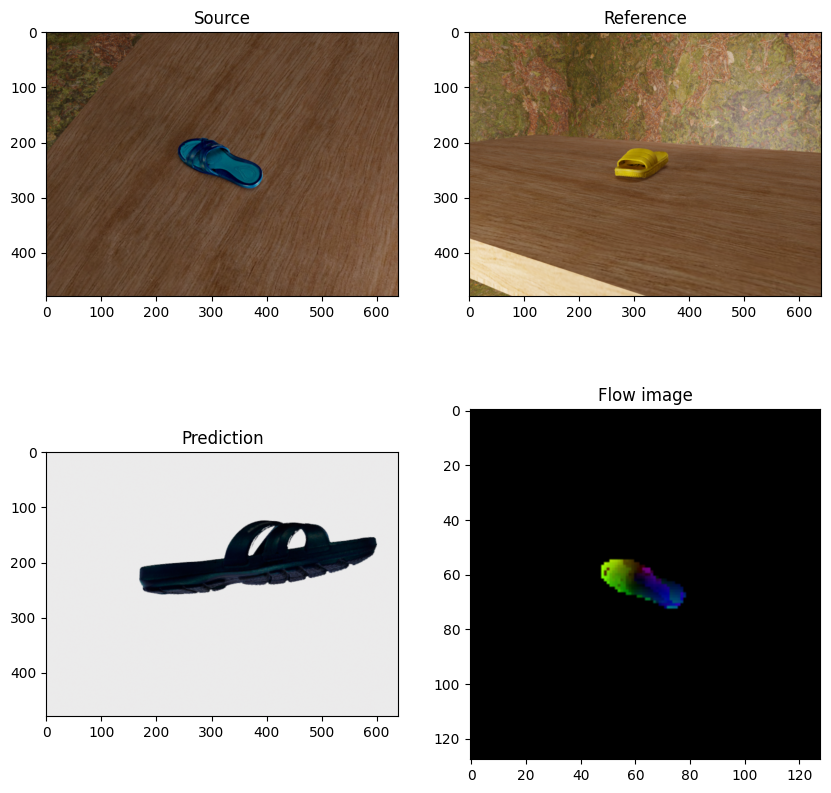

In [44]:
transform = np.linalg.inv(obj_to_cam)
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

model = o3d.io.read_triangle_model("../../data/housecat6d_meshes/shoe/shoe-aqua_cyan_right.obj")
mesh = model.meshes[0].mesh
mesh_name = model.meshes[0].mesh_name
mat = model.materials[0]

print(np.asarray(mesh.vertices))
print(np.max(np.asarray(mesh.vertices)))
rot_x_180 = np.eye(4)
rot_x_180[1, 1] = -1
rot_x_180[2, 2] = -1
mesh.transform((rot_x_180 @ transform))
print(np.asarray(mesh.vertices))
print(np.max(np.asarray(mesh.vertices)))

width = 640  
height = 480  
intrinsics = np.array([[538.391033533567, 0.0, 315.3074696331638], 
                       [0.0, 538.085452058436, 233.0483557773859], 
                       [0.0, 0.0, 1.0]], dtype=np.float64)
fx = intrinsics[0, 0]
fy = intrinsics[1, 1]
cx = intrinsics[0, 2]
cy = intrinsics[1, 2]

intrinsics = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

if 'renderer' in globals():
    del renderer
renderer = o3d.visualization.rendering.OffscreenRenderer(width, height)
renderer.scene.add_geometry(mesh_name, mesh, mat)
renderer.setup_camera(intrinsics, np.eye(4, dtype=np.float64))
img = renderer.render_to_image()
img_np = np.asarray(img)
# print both
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(img_src)
plt.title("Source")
plt.subplot(2, 2, 2)
plt.imshow(img_ref)
plt.title("Reference")
plt.subplot(2, 2, 3)
plt.imshow(img_np)
plt.title("Prediction")
plt.subplot(2,2,4)
plt.imshow(ds_predict.flow_images[vis_idx].squeeze(0).permute(1, 2, 0).numpy().astype(np.uint8))
plt.title("Flow image")
plt.show()


- pretrained weights for resnet18 (full retraining, only layer 4)
- different rotation representations (quats), https://github.com/naver/roma
- same for resnet34
- novel object for same category